In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

import os
from glob import glob

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#! kaggle datasets download -d bulentsiyah/semantic-drone-dataset
#! unzip semantic-drone-dataset.zip -d sem-drone

In [3]:
dirs = os.listdir("sem-drone")
dirs

['class_dict_seg.csv', 'dataset', 'RGB_color_image_masks']

In [4]:
os.listdir(os.path.join('sem-drone', 'RGB_color_image_masks', 'RGB_color_image_masks'))[:5]

['000.png', '001.png', '002.png', '003.png', '004.png']

In [5]:
os.listdir(os.path.join('sem-drone', 'dataset', 'semantic_drone_dataset'))

['label_images_semantic', 'original_images']

In [6]:
os.listdir(os.path.join('sem-drone', 'dataset', 'semantic_drone_dataset', 'label_images_semantic'))[:5]

['000.png', '001.png', '002.png', '003.png', '004.png']

In [7]:
os.listdir(os.path.join('sem-drone', 'dataset', 'semantic_drone_dataset', 'original_images'))[:5]

['000.jpg', '001.jpg', '002.jpg', '003.jpg', '004.jpg']

In [8]:
config = {
    'BASE_PATH': os.path.join('sem-drone', 'dataset', 'semantic_drone_dataset'),
    'IMG_PATH': os.path.join('sem-drone', 'dataset', 'semantic_drone_dataset', 'original_images'),
    'LABEL_PATH': os.path.join('sem-drone', 'dataset', 'semantic_drone_dataset', 'label_images_semantic'),
    'RGB_MASK_PATH': os.path.join('sem-drone', 'RGB_color_image_masks', 'RGB_color_image_masks'),
    'CLASS_DICT': os.path.join('sem-drone', 'class_dict_seg.csv'),
    'NUM_CLASSES': 24,
    'BATCH_SIZE': 2,
    'IMAGE_SIZE': 512
}

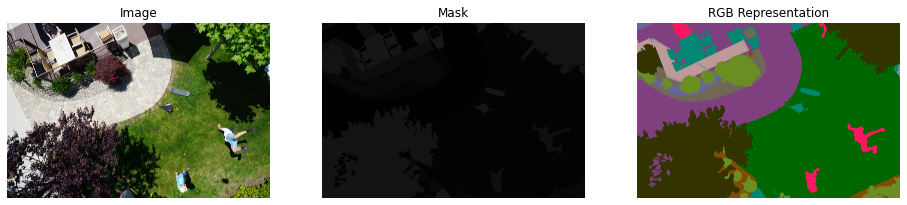

In [9]:
def visualize_trio(img_num):
    img = cv2.imread(os.path.join(config['IMG_PATH'], f'{img_num}.jpg'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(os.path.join(config['LABEL_PATH'], f'{img_num}.png'))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    rgb = cv2.imread(os.path.join(config['RGB_MASK_PATH'], f'{img_num}.png'))
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, 3, figsize=(16, 8))
    ax[0].imshow(img)
    ax[1].imshow(mask)
    ax[2].imshow(rgb)
    
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[0].set_title('Image')
    ax[1].set_title('Mask')
    ax[2].set_title('RGB Representation')
    plt.show()
    
visualize_trio(408)

In [10]:
mask = cv2.imread(os.path.join(config['LABEL_PATH'], '408.png'))
print(mask.shape)
print(mask)

(4000, 6000, 3)
[[[10 10 10]
  [10 10 10]
  [10 10 10]
  ...
  [19 19 19]
  [19 19 19]
  [19 19 19]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  ...
  [19 19 19]
  [19 19 19]
  [19 19 19]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  ...
  [19 19 19]
  [19 19 19]
  [19 19 19]]

 ...

 [[19 19 19]
  [19 19 19]
  [19 19 19]
  ...
  [ 8  8  8]
  [ 8  8  8]
  [ 8  8  8]]

 [[19 19 19]
  [19 19 19]
  [19 19 19]
  ...
  [ 8  8  8]
  [ 8  8  8]
  [ 8  8  8]]

 [[19 19 19]
  [19 19 19]
  [19 19 19]
  ...
  [ 8  8  8]
  [ 8  8  8]
  [ 8  8  8]]]


In [11]:
image_paths =  glob(os.path.join(config['IMG_PATH'], '*'), recursive=True)
mask_paths =  glob(os.path.join(config['LABEL_PATH'], '*'), recursive=True)

image_paths_train, image_paths_test, mask_paths_train, mask_paths_test = train_test_split(image_paths, mask_paths, shuffle=True)

In [12]:
print(image_paths_train[:5])
print(mask_paths_train[:5])

['sem-drone\\dataset\\semantic_drone_dataset\\original_images\\533.jpg', 'sem-drone\\dataset\\semantic_drone_dataset\\original_images\\258.jpg', 'sem-drone\\dataset\\semantic_drone_dataset\\original_images\\538.jpg', 'sem-drone\\dataset\\semantic_drone_dataset\\original_images\\593.jpg', 'sem-drone\\dataset\\semantic_drone_dataset\\original_images\\386.jpg']
['sem-drone\\dataset\\semantic_drone_dataset\\label_images_semantic\\533.png', 'sem-drone\\dataset\\semantic_drone_dataset\\label_images_semantic\\258.png', 'sem-drone\\dataset\\semantic_drone_dataset\\label_images_semantic\\538.png', 'sem-drone\\dataset\\semantic_drone_dataset\\label_images_semantic\\593.png', 'sem-drone\\dataset\\semantic_drone_dataset\\label_images_semantic\\386.png']


In [13]:
print(image_paths_test[:5])
print(mask_paths_test[:5])

['sem-drone\\dataset\\semantic_drone_dataset\\original_images\\508.jpg', 'sem-drone\\dataset\\semantic_drone_dataset\\original_images\\596.jpg', 'sem-drone\\dataset\\semantic_drone_dataset\\original_images\\102.jpg', 'sem-drone\\dataset\\semantic_drone_dataset\\original_images\\320.jpg', 'sem-drone\\dataset\\semantic_drone_dataset\\original_images\\303.jpg']
['sem-drone\\dataset\\semantic_drone_dataset\\label_images_semantic\\508.png', 'sem-drone\\dataset\\semantic_drone_dataset\\label_images_semantic\\596.png', 'sem-drone\\dataset\\semantic_drone_dataset\\label_images_semantic\\102.png', 'sem-drone\\dataset\\semantic_drone_dataset\\label_images_semantic\\320.png', 'sem-drone\\dataset\\semantic_drone_dataset\\label_images_semantic\\303.png']


In [14]:
print(len(image_paths_train))
print(len(image_paths_test))

300
100


In [15]:
config['DATASET_LENGTH'] = len(image_paths_train)

In [16]:
import albumentations as A

def preprocess(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size=[config['IMAGE_SIZE'], config['IMAGE_SIZE']])
    img = tf.cast(img, tf.float32) / 255.0
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, size=[config['IMAGE_SIZE'], config['IMAGE_SIZE']])
    mask = tf.cast(mask, tf.float32)
    
    return img, mask

# TF augmentations can be used, but are relatively rigid
def augment_dataset_tf(img, mask):
     #  Augmentations should always be performed on both an input image and a mask if applied at all
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.rot90(img)
        mask = tf.image.rot90(mask)
            
    return img, mask


def create_dataset_tf(images, masks, augment):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks)).shuffle(len(images))
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        dataset = dataset.map(wrapper)
        dataset = dataset.batch(config['BATCH_SIZE'], drop_remainder=True).prefetch(tf.data.AUTOTUNE).repeat()
    else:
        dataset = dataset.batch(config['BATCH_SIZE'], drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return dataset

def create_dataset(images, masks, augment):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks)).shuffle(len(images))
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        dataset = dataset.map(apply_albumentations, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(config['BATCH_SIZE'], drop_remainder=True).prefetch(tf.data.AUTOTUNE).repeat()
    else:
        dataset = dataset.batch(config['BATCH_SIZE'], drop_remainder=True).prefetch(tf.data.AUTOTUNE)

    return dataset


# https://albumentations.ai/docs/examples/tensorflow-example/
def albumentations(img, mask):
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.Transpose(p=0.5),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=70),
        A.CoarseDropout(p=0.5, max_holes=12, max_height=24, max_width=24)
    ])
        
    transformed = transform(image=img, mask=mask)
    transformed_image = transformed['image']
    transformed_mask = transformed['mask']
        
    transformed_image = tf.cast(transformed_image, tf.float32)
    transformed_mask = tf.cast(transformed_mask, tf.float32)
    return transformed_image, transformed_mask
    
def apply_albumentations(img, mask):
    aug_img, aug_mask = tf.numpy_function(func=albumentations, inp=[img, mask], Tout=[tf.float32, tf.float32])
    aug_img = tf.ensure_shape(aug_img, shape=[config['IMAGE_SIZE'], config['IMAGE_SIZE'], 3])
    aug_mask = tf.ensure_shape(aug_mask, shape=[config['IMAGE_SIZE'], config['IMAGE_SIZE'], 1])
    return aug_img, aug_mask

In [17]:
train_set = create_dataset(image_paths_train, mask_paths_train, augment=True)
test_set = create_dataset(image_paths_test, mask_paths_test, augment=False)

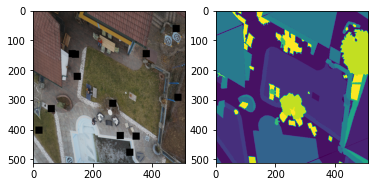

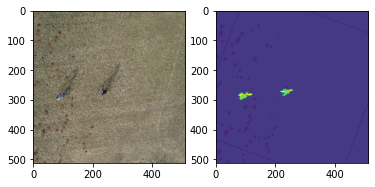

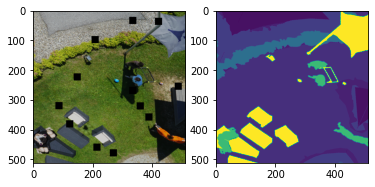

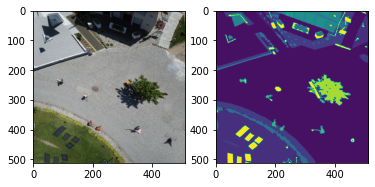

In [18]:
for img_batch, mask_batch in train_set.take(2):
    for i in range(len(img_batch)):
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(img_batch[i].numpy())
        ax[1].imshow(mask_batch[i].numpy())

In [19]:
print("Train Dataset:", train_set)

Train Dataset: <RepeatDataset element_spec=(TensorSpec(shape=(2, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2, 512, 512, 1), dtype=tf.float32, name=None))>


In [20]:
# Turns into atrous_block with dilation_rate > 1
def conv_block(block_input, num_filters=256, kernel_size=(3, 3), dilation_rate=1, padding="same"):
    x = keras.layers.Conv2D(num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding="same")(block_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    return x

# Atrous Spatial Pyramid Pooling
def ASPP(inputs):
    conv_1 = conv_block(inputs, kernel_size=(1, 1), dilation_rate=1)
    conv_6 = conv_block(inputs, kernel_size=(3, 3), dilation_rate=6)
    conv_12 = conv_block(inputs, kernel_size=(3, 3), dilation_rate=12)
    conv_18 = conv_block(inputs, kernel_size=(3, 3), dilation_rate=18)
    
    dims = inputs.shape
    # Image Pooling -> (256, 256, 3) -> (1, 1, filter_num) -> (32, 32, 256)
    x = keras.layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(inputs)
    x = conv_block(x, kernel_size=1)
    out_pool = keras.layers.UpSampling2D(size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]))(x)

    x = keras.layers.Concatenate()([conv_1, conv_6, conv_12, conv_18, out_pool])
    return conv_block(x, kernel_size=1)

In [21]:
keras.applications.ResNet101(weights="imagenet", include_top=False, input_shape=[512, 512, 3]).summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

 conv2_block2_add (Add)         (None, 128, 128, 25  0           ['conv2_block1_out[0][0]',       
                                6)                                'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, 128, 128, 25  0           ['conv2_block2_add[0][0]']       
                                6)                                                                
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 128, 128, 64  16448       ['conv2_block2_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 128, 128, 64  256        ['conv2_block3_1_conv[0][0]']    
 ization) 

 conv3_block2_3_conv (Conv2D)   (None, 64, 64, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 64, 64, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 64, 64, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 64, 64, 512)  0           ['conv3_block2_add[0][0]']       
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_add (Add)         (None, 32, 32, 1024  0           ['conv4_block1_0_bn[0][0]',      
                                )                                 'conv4_block1_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 32, 32, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block4_add (Add)         (None, 32, 32, 1024  0           ['conv4_block3_out[0][0]',       
                                )                                 'conv4_block4_3_bn[0][0]']      
          

 conv4_block7_2_relu (Activatio  (None, 32, 32, 256)  0          ['conv4_block7_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_3_conv (Conv2D)   (None, 32, 32, 1024  263168      ['conv4_block7_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block7_3_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block7_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block7_add (Add)         (None, 32, 32, 1024  0           ['conv4_block6_out[0][0]',       
          

                                                                                                  
 conv4_block10_2_relu (Activati  (None, 32, 32, 256)  0          ['conv4_block10_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_3_conv (Conv2D)  (None, 32, 32, 1024  263168      ['conv4_block10_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block10_3_bn (BatchNorma  (None, 32, 32, 1024  4096       ['conv4_block10_3_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_blo

 lization)                                                                                        
                                                                                                  
 conv4_block13_2_relu (Activati  (None, 32, 32, 256)  0          ['conv4_block13_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block13_3_conv (Conv2D)  (None, 32, 32, 1024  263168      ['conv4_block13_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block13_3_bn (BatchNorma  (None, 32, 32, 1024  4096       ['conv4_block13_3_conv[0][0]']   
 lization)                      )                                                                 
          

 conv4_block16_2_bn (BatchNorma  (None, 32, 32, 256)  1024       ['conv4_block16_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_2_relu (Activati  (None, 32, 32, 256)  0          ['conv4_block16_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_3_conv (Conv2D)  (None, 32, 32, 1024  263168      ['conv4_block16_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block16_3_bn (BatchNorma  (None, 32, 32, 1024  4096       ['conv4_block16_3_conv[0][0]']   
 lization)

                                                                                                  
 conv4_block19_2_bn (BatchNorma  (None, 32, 32, 256)  1024       ['conv4_block19_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block19_2_relu (Activati  (None, 32, 32, 256)  0          ['conv4_block19_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block19_3_conv (Conv2D)  (None, 32, 32, 1024  263168      ['conv4_block19_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_blo

 conv4_block22_2_conv (Conv2D)  (None, 32, 32, 256)  590080      ['conv4_block22_1_relu[0][0]']   
                                                                                                  
 conv4_block22_2_bn (BatchNorma  (None, 32, 32, 256)  1024       ['conv4_block22_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block22_2_relu (Activati  (None, 32, 32, 256)  0          ['conv4_block22_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block22_3_conv (Conv2D)  (None, 32, 32, 1024  263168      ['conv4_block22_2_relu[0][0]']   
                                )                                                                 
          

                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 16, 16, 512)  2048       ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 16, 16, 512)  0          ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 16, 16, 512)  2359808     ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_2_bn (BatchNormal  (None, 16, 16, 512)  2048       ['conv5_block2_2_conv[0][0]']    
 ization) 

In [22]:
keras.applications.EfficientNetV2B0(weights="imagenet", include_top=False, input_shape=[512, 512, 3]).summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 512, 512, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 512, 512, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 256, 256, 32  864         ['normalization[0

 block3b_expand_activation (Act  (None, 64, 64, 192)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_project_conv (Conv2D)  (None, 64, 64, 48)   9216        ['block3b_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 64, 64, 48)  192         ['block3b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3b_drop (Dropout)         (None, 64, 64, 48)   0           ['block3b_project_bn[0][0]']     
          

                                                                                                  
 block4b_add (Add)              (None, 32, 32, 96)   0           ['block4b_drop[0][0]',           
                                                                  'block4a_project_bn[0][0]']     
                                                                                                  
 block4c_expand_conv (Conv2D)   (None, 32, 32, 384)  36864       ['block4b_add[0][0]']            
                                                                                                  
 block4c_expand_bn (BatchNormal  (None, 32, 32, 384)  1536       ['block4c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4c_expand_activation (Act  (None, 32, 32, 384)  0          ['block4c_expand_bn[0][0]']      
 ivation) 

 ivation)                                                                                         
                                                                                                  
 block5b_dwconv2 (DepthwiseConv  (None, 32, 32, 672)  6048       ['block5b_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block5b_bn (BatchNormalization  (None, 32, 32, 672)  2688       ['block5b_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block5b_activation (Activation  (None, 32, 32, 672)  0          ['block5b_bn[0][0]']             
 )                                                                                                
          

 block5d_bn (BatchNormalization  (None, 32, 32, 672)  2688       ['block5d_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block5d_activation (Activation  (None, 32, 32, 672)  0          ['block5d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5d_se_squeeze (GlobalAver  (None, 672)         0           ['block5d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5d_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block5d_se_squeeze[0][0]']     
          

                                                                                                  
 block6a_se_squeeze (GlobalAver  (None, 672)         0           ['block6a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6a_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block6a_se_squeeze[0][0]']     
                                                                                                  
 block6a_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block6a_se_reshape[0][0]']     
                                                                                                  
 block6a_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block6a_se_reduce[0][0]']      
                                                                                                  
 block6a_s

 block6c_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6c_se_reduce[0][0]']      
                                                                                                  
 block6c_se_excite (Multiply)   (None, 16, 16, 1152  0           ['block6c_activation[0][0]',     
                                )                                 'block6c_se_expand[0][0]']      
                                                                                                  
 block6c_project_conv (Conv2D)  (None, 16, 16, 192)  221184      ['block6c_se_excite[0][0]']      
                                                                                                  
 block6c_project_bn (BatchNorma  (None, 16, 16, 192)  768        ['block6c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6c_d

                                )                                 'block6e_se_expand[0][0]']      
                                                                                                  
 block6e_project_conv (Conv2D)  (None, 16, 16, 192)  221184      ['block6e_se_excite[0][0]']      
                                                                                                  
 block6e_project_bn (BatchNorma  (None, 16, 16, 192)  768        ['block6e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6e_drop (Dropout)         (None, 16, 16, 192)  0           ['block6e_project_bn[0][0]']     
                                                                                                  
 block6e_add (Add)              (None, 16, 16, 192)  0           ['block6e_drop[0][0]',           
          

                                                                                                  
 block6g_project_bn (BatchNorma  (None, 16, 16, 192)  768        ['block6g_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6g_drop (Dropout)         (None, 16, 16, 192)  0           ['block6g_project_bn[0][0]']     
                                                                                                  
 block6g_add (Add)              (None, 16, 16, 192)  0           ['block6g_drop[0][0]',           
                                                                  'block6f_add[0][0]']            
                                                                                                  
 block6h_expand_conv (Conv2D)   (None, 16, 16, 1152  221184      ['block6g_add[0][0]']            
          

In [23]:
def define_deeplabv3_plus(image_size, num_classes, backbone):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    
    if backbone == 'resnet':
        resnet101 = keras.applications.ResNet101(
            weights="imagenet", 
            include_top=False, 
            input_tensor=model_input)
        x = resnet101.get_layer("conv4_block6_2_relu").output
        low_level = resnet101.get_layer("conv2_block3_2_relu").output
        
    elif backbone == 'effnet':
        effnet = keras.applications.EfficientNetV2B0(
            weights="imagenet", 
             include_top=False, 
             input_tensor=model_input)
        x = effnet.get_layer("block5e_activation").output
        low_level = effnet.get_layer("block2a_expand_activation").output
        
    aspp_result = ASPP(x)
    upsampled_aspp = keras.layers.UpSampling2D(size=(4, 4))(aspp_result)
    
    low_level = conv_block(low_level, num_filters=48, kernel_size=1)

    x = keras.layers.Concatenate()([upsampled_aspp, low_level])
    x = conv_block(x)
    x = keras.layers.UpSampling2D(size=(4, 4))(x)
    model_output = keras.layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", activation='softmax')(x)
    return keras.Model(inputs=model_input, outputs=model_output)

In [24]:
model = define_deeplabv3_plus(config['IMAGE_SIZE'], config['NUM_CLASSES'], 'resnet')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

 conv2_block2_add (Add)         (None, 128, 128, 25  0           ['conv2_block1_out[0][0]',       
                                6)                                'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, 128, 128, 25  0           ['conv2_block2_add[0][0]']       
                                6)                                                                
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 128, 128, 64  16448       ['conv2_block2_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 128, 128, 64  256        ['conv2_block3_1_conv[0][0]']    
 ization) 

 conv3_block2_3_conv (Conv2D)   (None, 64, 64, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 64, 64, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 64, 64, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 64, 64, 512)  0           ['conv3_block2_add[0][0]']       
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_add (Add)         (None, 32, 32, 1024  0           ['conv4_block1_0_bn[0][0]',      
                                )                                 'conv4_block1_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 32, 32, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block4_add (Add)         (None, 32, 32, 1024  0           ['conv4_block3_out[0][0]',       
                                )                                 'conv4_block4_3_bn[0][0]']      
          

 batch_normalization_3 (BatchNo  (None, 32, 32, 256)  1024       ['conv2d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_4 (Activation)      (None, 1, 1, 256)    0           ['batch_normalization_4[0][0]']  
                                                                                                  
 activation (Activation)        (None, 32, 32, 256)  0           ['batch_normalization[0][0]']    
                                                                                                  
 activation_1 (Activation)      (None, 32, 32, 256)  0           ['batch_normalization_1[0][0]']  
                                                                                                  
 activation_2 (Activation)      (None, 32, 32, 256)  0           ['batch_normalization_2[0][0]']  
          

In [25]:
# Default TF MeanIoU has a known bug
class MeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
        super(MeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

In [26]:
from keras import backend as K

# Tversky loss is generalized Dice Loss (alpha=beta=0.5)
# https://arxiv.org/abs/1706.05721
def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=config['NUM_CLASSES'])[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [27]:
reduceLr = keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.3, monitor='val_sparse_categorical_accuracy')
early_stopping = keras.callbacks.EarlyStopping(patience=10, monitor='val_sparse_categorical_accuracy', restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint(filepath='deeplabv3plus.h5')


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    #loss=soft_dice_loss,
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy", 
              MeanIoU(num_classes=config['NUM_CLASSES']),
              dice_coef])

history = model.fit(train_set, 
                    epochs=100, 
                    steps_per_epoch=int(config['DATASET_LENGTH']/config['BATCH_SIZE']), 
                    validation_data=test_set,
                    callbacks=[reduceLr, early_stopping, checkpoint])

Epoch 1/100
150/150 [==============================] - 46s 235ms/step - loss: 2.1781 - sparse_categorical_accuracy: 0.4457 - mean_io_u: 0.0643 - dice_coef: 0.2716 - val_loss: 22.3000 - val_sparse_categorical_accuracy: 0.0542 - val_mean_io_u: 0.0066 - val_dice_coef: 0.0420 - lr: 5.0000e-05
Epoch 2/100
150/150 [==============================] - 35s 230ms/step - loss: 1.4357 - sparse_categorical_accuracy: 0.6276 - mean_io_u: 0.1105 - dice_coef: 0.4604 - val_loss: 153.9863 - val_sparse_categorical_accuracy: 0.0294 - val_mean_io_u: 0.0057 - val_dice_coef: 0.0298 - lr: 5.0000e-05
Epoch 3/100
150/150 [==============================] - 36s 235ms/step - loss: 1.2047 - sparse_categorical_accuracy: 0.6684 - mean_io_u: 0.1427 - dice_coef: 0.5228 - val_loss: 70.5143 - val_sparse_categorical_accuracy: 0.0718 - val_mean_io_u: 0.0056 - val_dice_coef: 0.0722 - lr: 5.0000e-05
Epoch 4/100
150/150 [==============================] - 36s 240ms/step - loss: 1.0940 - sparse_categorical_accuracy: 0.6890 - mean

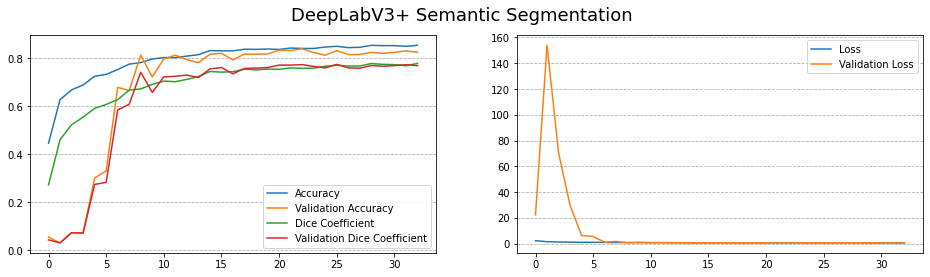

In [28]:
acc, val_acc = history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy']
dice_coef, val_dice_coef = history.history['dice_coef'], history.history['val_dice_coef']
loss, val_loss = history.history['loss'], history.history['val_loss']
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle('DeepLabV3+ Semantic Segmentation', fontsize=18)

ax[0].plot(acc, label='Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].grid(axis='y', linestyle='--')

ax[0].plot(dice_coef, label='Dice Coefficient')
ax[0].plot(val_dice_coef, label='Validation Dice Coefficient')
ax[0].grid(axis='y', linestyle='--')

ax[1].plot(loss, label='Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].grid(axis='y', linestyle='--')

ax[0].legend()
ax[1].legend()
plt.show()

In [29]:
class_dict_seg = pd.read_csv(config['CLASS_DICT'])
print(class_dict_seg.head())

         name    r    g    b
0   unlabeled    0    0    0
1  paved-area  128   64  128
2        dirt  130   76    0
3       grass    0  102    0
4      gravel  112  103   87


In [30]:
# Note the whitespaces before ' r', ' g' and ' b'
class_dict_seg.columns

Index(['name', ' r', ' g', ' b'], dtype='object')

In [31]:
# Note the whitespaces before ' r', ' g' and ' b'
rgb_rep = class_dict_seg[[' r', ' g', ' b']].values
rgb_rep[:10]

array([[  0,   0,   0],
       [128,  64, 128],
       [130,  76,   0],
       [  0, 102,   0],
       [112, 103,  87],
       [ 28,  42, 168],
       [ 48,  41,  30],
       [  0,  50,  89],
       [107, 142,  35],
       [ 70,  70,  70]], dtype=int64)

In [32]:
classes = class_dict_seg['name'].values
classes

array(['unlabeled', 'paved-area', 'dirt', 'grass', 'gravel', 'water',
       'rocks', 'pool', 'vegetation', 'roof', 'wall', 'window', 'door',
       'fence', 'fence-pole', 'person', 'dog', 'car', 'bicycle', 'tree',
       'bald-tree', 'ar-marker', 'obstacle', 'conflicting'], dtype=object)

In [33]:
def visualize_predictions(img_num):
    if os.path.exists(os.path.join(config['IMG_PATH'], f'{img_num}.jpg')):
        img = tf.io.read_file(os.path.join(config['IMG_PATH'], f'{img_num}.jpg'))
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, size=[config['IMAGE_SIZE'], config['IMAGE_SIZE']])
        img = tf.cast(img, tf.float32) / 255.0

        mask = cv2.imread(os.path.join(config['LABEL_PATH'], f'{img_num}.png'))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask,  [config['IMAGE_SIZE'], config['IMAGE_SIZE']])
        rgb = cv2.imread(os.path.join(config['RGB_MASK_PATH'], f'{img_num}.png'))
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        rgb = cv2.resize(rgb,  [config['IMAGE_SIZE'], config['IMAGE_SIZE']])

        pred = model.predict(np.expand_dims(img, 0), verbose=0)
        predictions = np.argmax(pred, axis=-1)
        representation = rgb_rep[predictions]

        fig, ax = plt.subplots(1, 4, figsize=(16, 8))
        ax[0].imshow(img)
        ax[1].imshow(mask)
        ax[2].imshow(rgb)
        ax[3].imshow(representation.squeeze())

        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')
        ax[3].axis('off')
        ax[0].set_title('Image')
        ax[1].set_title('Mask')
        ax[2].set_title('RGB Representation')
        ax[3].set_title('Prediction')
        plt.show()

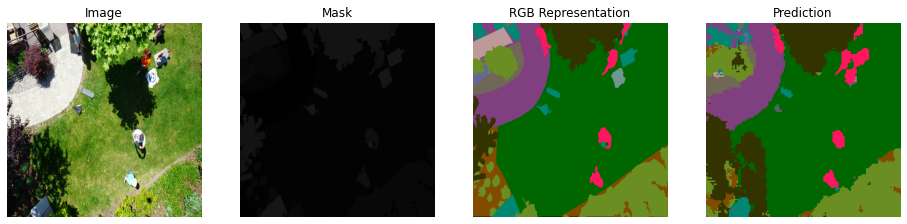

In [34]:
visualize_predictions(472)

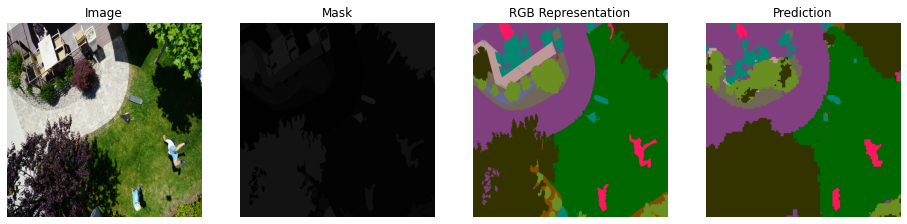

In [35]:
visualize_predictions(408)

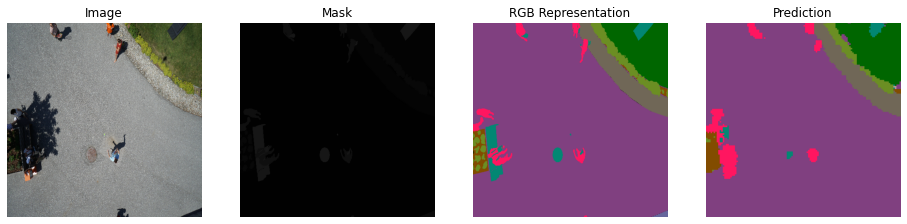

In [36]:
visualize_predictions(109)

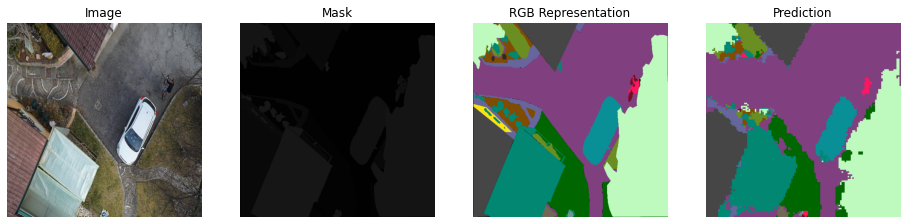

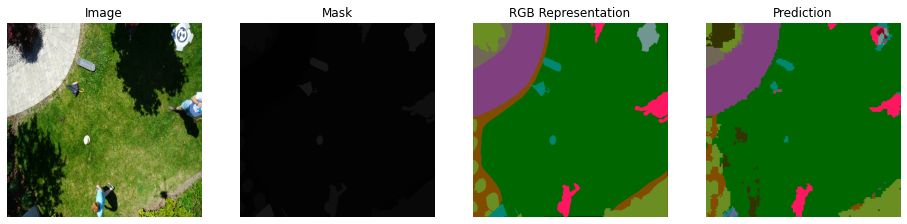

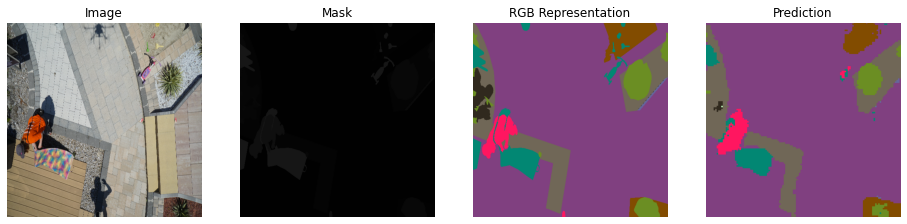

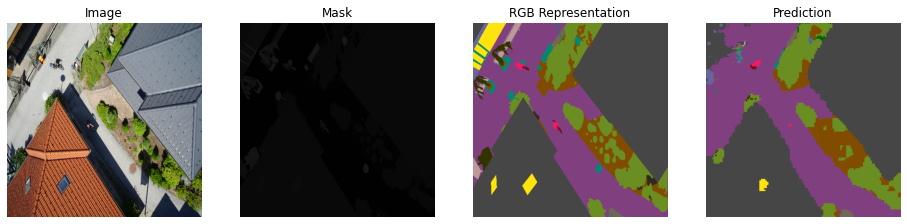

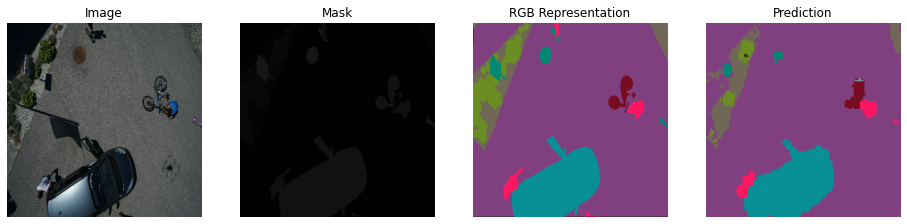

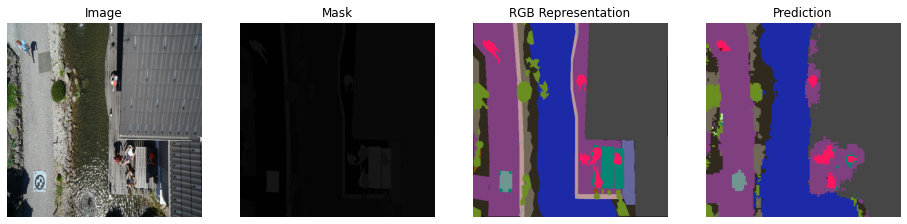

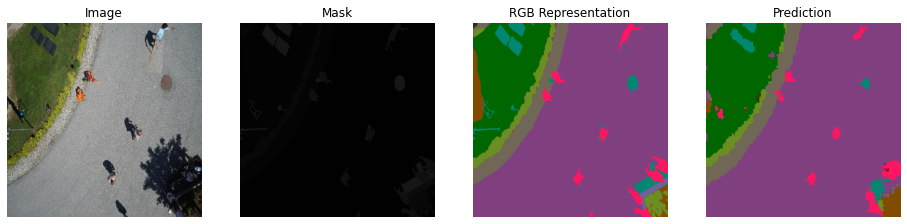

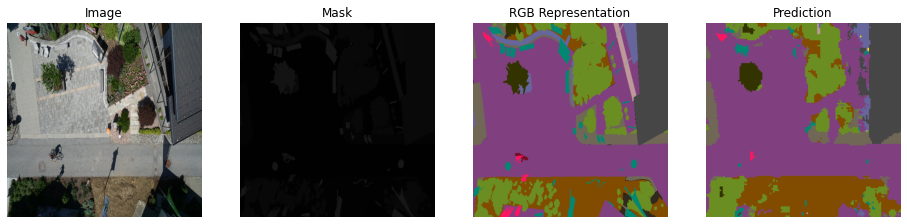

In [37]:
for i in range(150, 160):
    visualize_predictions(i)

In [38]:
def predict_and_overlay(img_num):
    if os.path.exists(os.path.join(config['IMG_PATH'], f'{img_num}.jpg')):

        img = cv2.imread(os.path.join(config['IMG_PATH'], f'{img_num}.jpg'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,  [config['IMAGE_SIZE'], config['IMAGE_SIZE']])
        img = img/255.0

        pred = model.predict(np.expand_dims(img, 0), verbose=0)
        predictions = np.argmax(pred, axis=-1)
        representation = rgb_rep[predictions]

        fig, ax = plt.subplots(1, figsize=(16, 8))
        ax.imshow(img)
        ax.imshow(representation.squeeze(), alpha=0.5)
        ax.axis('off')

        plt.show()

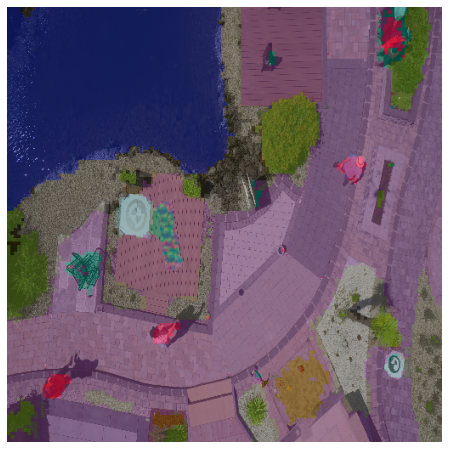

In [39]:
predict_and_overlay(206)

In [40]:
def predict_img(img):
        pred = model.predict(np.expand_dims(img, 0), verbose=0)
        predictions = np.argmax(pred, axis=-1)
        representation = rgb_rep[predictions]

        fig, ax = plt.subplots(1, 3, figsize=(16, 8))
        ax[0].imshow(img)
        ax[1].imshow(img, alpha=0.5)
        ax[1].imshow(representation.squeeze(), alpha=0.5)
        ax[2].imshow(representation.squeeze())
        #ax.axis('off')

        plt.show()

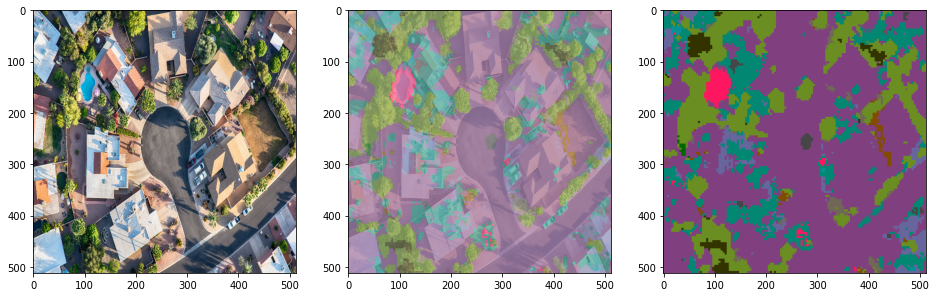

In [41]:
import urllib.request
from tensorflow.keras.preprocessing import image

url = 'https://wp-tid.zillowstatic.com/8/PARC_Feature_Drones_3200x2134-225fba.png'

def url_to_array(url):
    req = urllib.request.urlopen(url)
    arr = np.array(bytearray(req.read()), dtype=np.int8)
    img = cv2.imdecode(arr, -1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,  [config['IMAGE_SIZE'], config['IMAGE_SIZE']])
    img = img/255.0
    return img

img = url_to_array(url)
predict_img(img)